In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import rc       
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
import pandas as pd
import numpy as np

rc('font', family='NanumGothic')               
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df1 = pd.read_csv("/Users/ijongseung/Documents/GitHub/CHP-project/gangnam_CHP.csv")
df1["date"] = pd.to_datetime(df1["date"])

In [6]:
df1.set_index("date", inplace=True)

In [7]:
Y_COL = "heat_demand"
TEMP_COL = "imputated_temperature"  # 없으면 본인 컬럼명으로 변경

assert isinstance(df1.index, pd.DatetimeIndex), "df index must be DatetimeIndex"
assert Y_COL in df1.columns, f"Missing {Y_COL}"
assert TEMP_COL in df1.columns, f"Missing {TEMP_COL}"

df1[[Y_COL, TEMP_COL]].head()


# 가정: pip install workalendar
# (사용 패키지명은 workcalendar가 아니라 workalendar 입니다)

import pandas as pd
from workalendar.asia import SouthKorea

cal = SouthKorea()


df1 = df1.sort_index()
df1["is_weekend"] = (df1.index.dayofweek >= 5).astype(int)


dates = df1.index.normalize() # 시간 단위가 아닌 날짜만 남기기
unique_dates = pd.Index(dates.unique())

holiday_map = {d: int(cal.is_holiday(d.date())) for d in unique_dates}

# 매핑 처리
df1["is_holiday"] = dates.map(holiday_map).astype(int)

# 평일만 처리하는 경우
df1["is_offday"] = ((df1["is_weekend"] == 1) | (df1["is_holiday"] == 1)).astype(int)

In [8]:
# HDH 생성 -> 냉난방도일에 대한 생성

T_base = 18.0  # 일단 고정(나중에 CV 가능)
df1["hdh"] = np.maximum(0.0, T_base - df1["imputated_temperature"].astype(float))

## train-val-test 부분 확인처리 필요

In [9]:
t0 = df1.index[0]
df1["t_hours"] = (df1.index - t0).total_seconds() / 3600.0

In [10]:
total_len = len(df1)
train_end = int(total_len * 0.80)
val_end   = int(total_len * 0.90)

train_df = df1.iloc[:train_end].copy()
val_df   = df1.iloc[train_end:val_end].copy()
test_df  = df1.iloc[val_end:].copy()

print("total:", total_len)
print("train:", len(train_df), train_df.index.min(), train_df.index.max())
print("val  :", len(val_df),   val_df.index.min(),   val_df.index.max())
print("test :", len(test_df),  test_df.index.min(),  test_df.index.max())

total: 26279
train: 21023 2021-01-01 01:00:00 2023-05-26 23:00:00
val  : 2628 2023-05-27 00:00:00 2023-09-13 11:00:00
test : 2628 2023-09-13 12:00:00 2023-12-31 23:00:00


In [11]:
t0 = df1.index[0]  # 전체 데이터 시작점

def add_t_hours(dfx: pd.DataFrame) -> pd.DataFrame:
    out = dfx.copy()
    out["t_hours"] = (out.index - t0).total_seconds() / 3600.0
    return out

train_df = add_t_hours(train_df)
val_df   = add_t_hours(val_df)
test_df  = add_t_hours(test_df)

In [12]:
def generate_fourier_terms(timesteps: np.ndarray, period: float, K: int) -> np.ndarray:
    terms = []
    for k in range(1, K + 1):
        terms.append(np.sin(2 * np.pi * k * timesteps / period))
        terms.append(np.cos(2 * np.pi * k * timesteps / period))
    return np.stack(terms, axis=1)

daily_period = 24.0
yearly_period = 24.0 * 365.25


In [13]:
def build_X(dfx: pd.DataFrame, Kd: int, Ky: int) -> np.ndarray:
    t = dfx["t_hours"].values.astype(float)

    X_fourier = np.hstack([
        generate_fourier_terms(t, daily_period, Kd),
        generate_fourier_terms(t, yearly_period, Ky)
    ])

    X_other = np.column_stack([
        dfx["t_hours"].values.astype(float),    # trend
        dfx["hdh"].values.astype(float),        # weather (linear version)
        dfx["is_offday"].values.astype(float)   # social
    ])

    return np.hstack([X_other, X_fourier])


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

Best (Kd, Ky) = (np.int64(1), np.int64(4)) Val MSE = 1183.9930137366864


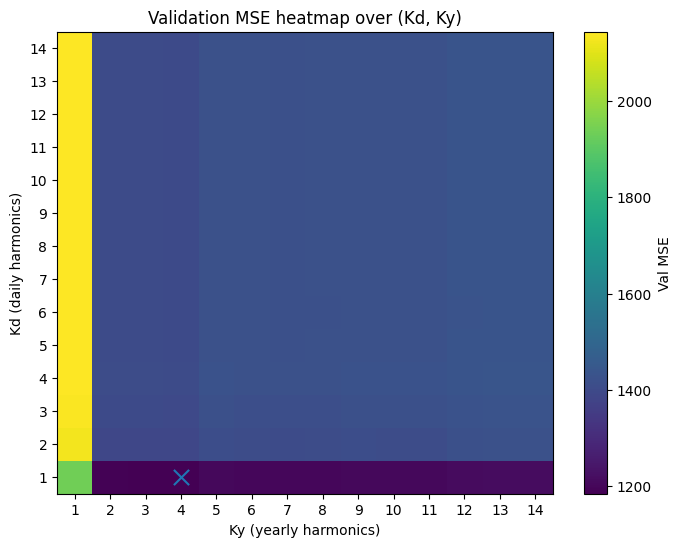

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

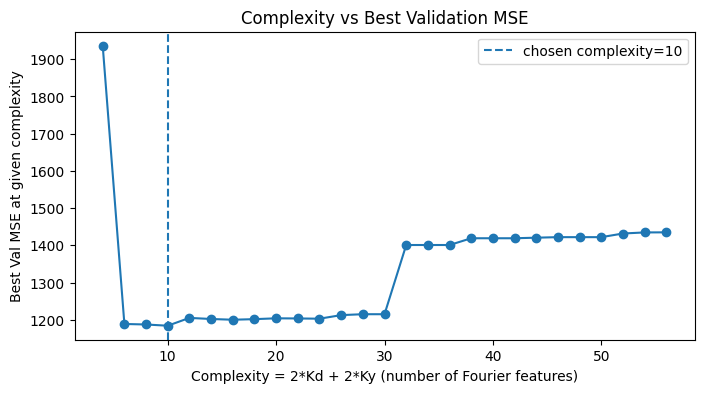

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

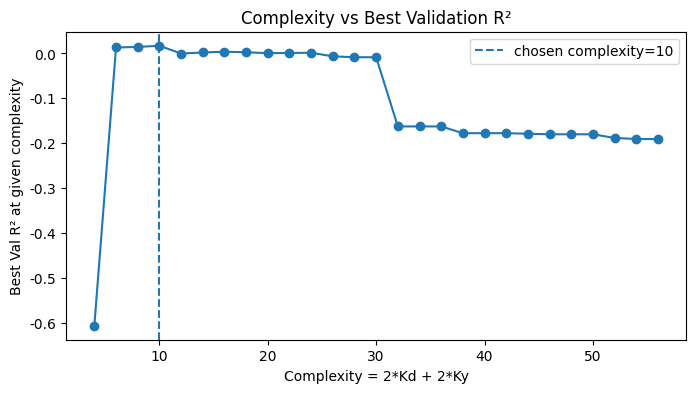

In [17]:
from sklearn.linear_model import LinearRegression

daily_K_vals = np.arange(1, 15)
yearly_K_vals = np.arange(1, 15)

y_train = train_df[Y_COL].values.astype(float)
y_val   = val_df[Y_COL].values.astype(float)

results = []
best_mse = float("inf")
best_K = None
best_model = None

for Kd, Ky in product(daily_K_vals, yearly_K_vals):
    X_train = build_X(train_df, Kd, Ky)
    X_val   = build_X(val_df,   Kd, Ky)

    model = LinearRegression().fit(X_train, y_train)
    val_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, val_pred)
    r2  = r2_score(y_val, val_pred)

    results.append({"Kd": Kd, "Ky": Ky, "mse": mse, "r2": r2, "complexity": (2*Kd + 2*Ky)})

    if mse < best_mse:
        best_mse = mse
        best_K = (Kd, Ky)
        best_model = model

results_df = pd.DataFrame(results)
print("Best (Kd, Ky) =", best_K, "Val MSE =", best_mse)


import matplotlib.pyplot as plt

Kd_best, Ky_best = best_K

pivot = results_df.pivot(index="Kd", columns="Ky", values="mse")

plt.figure(figsize=(8, 6))
plt.imshow(pivot.values, aspect="auto", origin="lower")
plt.colorbar(label="Val MSE")
plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
plt.yticks(np.arange(len(pivot.index)), pivot.index)
plt.xlabel("Ky (yearly harmonics)")
plt.ylabel("Kd (daily harmonics)")
plt.title("Validation MSE heatmap over (Kd, Ky)")

# best point marker
x = list(pivot.columns).index(Ky_best)
y = list(pivot.index).index(Kd_best)
plt.scatter([x], [y], marker="x", s=120)
plt.show()

# complexity(=2Kd+2Ky)별로 최저 MSE만 뽑기
frontier_mse = results_df.groupby("complexity")["mse"].min().reset_index().sort_values("complexity")
frontier_r2  = results_df.groupby("complexity")["r2"].max().reset_index().sort_values("complexity")

plt.figure(figsize=(8, 4))
plt.plot(frontier_mse["complexity"], frontier_mse["mse"], marker="o")
plt.axvline(2*Kd_best + 2*Ky_best, linestyle="--", label=f"chosen complexity={2*Kd_best+2*Ky_best}")
plt.xlabel("Complexity = 2*Kd + 2*Ky (number of Fourier features)")
plt.ylabel("Best Val MSE at given complexity")
plt.title("Complexity vs Best Validation MSE")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(frontier_r2["complexity"], frontier_r2["r2"], marker="o")
plt.axvline(2*Kd_best + 2*Ky_best, linestyle="--", label=f"chosen complexity={2*Kd_best+2*Ky_best}")
plt.xlabel("Complexity = 2*Kd + 2*Ky")
plt.ylabel("Best Val R² at given complexity")
plt.title("Complexity vs Best Validation R²")
plt.legend()
plt.show()

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

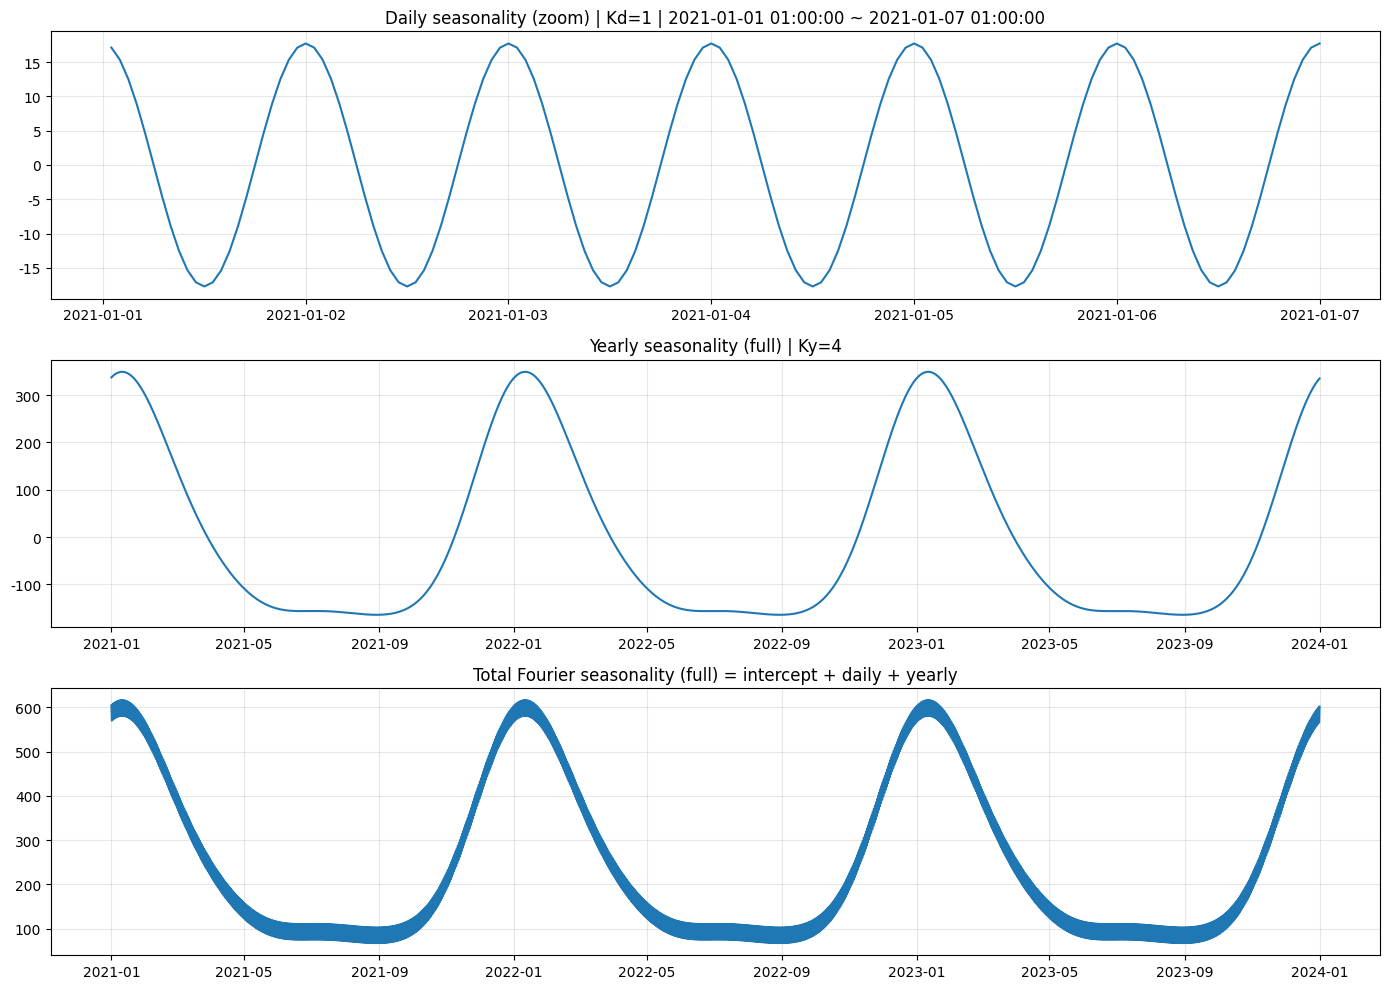

In [19]:
# 시간축
t0 = df1.index[0]
t_all = ((df1.index - t0).total_seconds() / 3600.0).astype(float).values

daily_period = 24.0
yearly_period = 365.25 * 24.0

def fourier_terms(timesteps, period, K):
    cols = []
    for k in range(1, K+1):
        cols.append(np.sin(2*np.pi*k*timesteps/period))
        cols.append(np.cos(2*np.pi*k*timesteps/period))
    return np.column_stack(cols)

Kd_best, Ky_best = best_K

# seasonality-only 회귀 (train+val로 fit)
y_all = df1[Y_COL].values.astype(float)
train_end = len(train_df)
val_end   = train_end + len(val_df)

t_trainval = t_all[:val_end]
y_trainval = y_all[:val_end]

X_d_tr = fourier_terms(t_trainval, daily_period, Kd_best)
X_y_tr = fourier_terms(t_trainval, yearly_period, Ky_best)
X_tr = np.hstack([X_d_tr, X_y_tr])

season_model = LinearRegression().fit(X_tr, y_trainval)

# 전체 성분 생성
X_d_all = fourier_terms(t_all, daily_period, Kd_best)
X_y_all = fourier_terms(t_all, yearly_period, Ky_best)

coef = season_model.coef_
intercept = season_model.intercept_

n_d = X_d_all.shape[1]
coef_d = coef[:n_d]
coef_y = coef[n_d:]

daily_comp   = X_d_all @ coef_d
yearly_comp  = X_y_all @ coef_y
total_season = intercept + daily_comp + yearly_comp

# -----------------------------
# Daily만 확대 구간 설정
# -----------------------------
start_dt = df1.index[0]            # 원하는 시작점으로 변경 가능
window_hours = 144                 # daily 확대 길이
end_dt = start_dt + pd.Timedelta(hours=window_hours)

mask = (df1.index >= start_dt) & (df1.index < end_dt)
x_zoom = df1.index[mask]
daily_zoom = daily_comp[mask]

# -----------------------------
# Plot: Daily(zoom), Yearly(full), Total(full)
# -----------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 10))  # sharex=False

# 1) Daily (zoom)
axes[0].plot(x_zoom, daily_zoom)
axes[0].set_title(f"Daily seasonality (zoom) | Kd={Kd_best} | {start_dt} ~ {end_dt}")
axes[0].grid(True, alpha=0.3)

# 2) Yearly (full)
axes[1].plot(df1.index, yearly_comp)
axes[1].set_title(f"Yearly seasonality (full) | Ky={Ky_best}")
axes[1].grid(True, alpha=0.3)

# 3) Total Fourier (full)
axes[2].plot(df1.index, total_season)
axes[2].set_title("Total Fourier seasonality (full) = intercept + daily + yearly")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [21]:
# hinge 생성
K_cp = 20  # 후보 changepoint 개수

n = len(df1)
lo = int(0.05 * n)
hi = int(0.95 * n)
cp_idx = np.linspace(lo, hi, K_cp, dtype=int)

cp_hours = df1["t_hours"].values[cp_idx]  # 후보 c_j

t = df1["t_hours"].values.reshape(-1, 1)
c = cp_hours.reshape(1, -1)

hinge = np.maximum(0.0, t - c)  # (n, K_cp)

hinge_cols = [f"hinge_{j}" for j in range(K_cp)]
hinge_df = pd.DataFrame(hinge, index=df1.index, columns=hinge_cols)

hinge_df.head()


,hinge_0,hinge_1,hinge_2,hinge_3,hinge_4,hinge_5,hinge_6,hinge_7,hinge_8,hinge_9,hinge_10,hinge_11,hinge_12,hinge_13,hinge_14,hinge_15,hinge_16,hinge_17,hinge_18,hinge_19
date,,,,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from sklearn.preprocessing import SplineTransformer

spline = SplineTransformer(n_knots=10, degree=3, include_bias=False)
hdh_spline = spline.fit_transform(df1[["hdh"]].values)

spline_cols = [f"hdh_spline_{i}" for i in range(hdh_spline.shape[1])]
spline_df = pd.DataFrame(hdh_spline, index=df1.index, columns=spline_cols)

spline_df.head()


,hdh_spline_0,hdh_spline_1,hdh_spline_2,hdh_spline_3,hdh_spline_4,hdh_spline_5,hdh_spline_6,hdh_spline_7,hdh_spline_8,hdh_spline_9,hdh_spline_10
date,,,,,,,,,,,
2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.021013,0.480062,0.478271,0.020655,0.0
2021-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.010530,0.413532,0.539628,0.036310,0.0
2021-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.002408,0.310879,0.614572,0.072141,0.0
2021-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.003257,0.327840,0.603892,0.065012,0.0
2021-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000251,0.229789,0.654283,0.115677,0.0


In [24]:
P_d = 24.0
P_y = 365.25 * 24.0

K_d = 1   # 일주기 harmonic 개수(1~3부터 시작 권장)
K_y = 4   # 연주기 harmonic 개수(1~3부터 시작 권장)

for k in range(1, K_d + 1):
    df1[f"cos_d_{k}"] = np.cos(2*np.pi*k*df1["t_hours"]/P_d)
    df1[f"sin_d_{k}"] = np.sin(2*np.pi*k*df1["t_hours"]/P_d)

for k in range(1, K_y + 1):
    df1[f"cos_y_{k}"] = np.cos(2*np.pi*k*df1["t_hours"]/P_y)
    df1[f"sin_y_{k}"] = np.sin(2*np.pi*k*df1["t_hours"]/P_y)

fourier_cols = [c for c in df1.columns if c.startswith(("cos_d_", "sin_d_", "cos_y_", "sin_y_"))]
df1[fourier_cols].head()


,cos_d_1,sin_d_1,cos_y_1,sin_y_1,cos_y_2,sin_y_2,cos_y_3,sin_y_3,cos_y_4,sin_y_4
date,,,,,,,,,,
2021-01-01 01:00:00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2021-01-01 02:00:00,0.965926,0.258819,1.000000,0.000717,0.999999,0.001434,0.999998,0.002150,0.999996,0.002867
2021-01-01 03:00:00,0.866025,0.500000,0.999999,0.001434,0.999996,0.002867,0.999991,0.004301,0.999984,0.005734
2021-01-01 04:00:00,0.707107,0.707107,0.999998,0.002150,0.999991,0.004301,0.999979,0.006451,0.999963,0.008601
2021-01-01 05:00:00,0.500000,0.866025,0.999996,0.002867,0.999984,0.005734,0.999963,0.008601,0.999934,0.011468


In [25]:
y = df1["heat_demand"].astype(float).values

X_parts = []

# trend (linear)
X_parts.append(df1[["t_hours"]])

# hinge (changepoints)
X_parts.append(hinge_df)

# weather spline
X_parts.append(spline_df)

# season Fourier
X_parts.append(df1[fourier_cols])

# social
X_parts.append(df1[["is_offday"]])

X = pd.concat(X_parts, axis=1)

print("X shape:", X.shape)
X.head()


X shape: (26279, 43)


,t_hours,hinge_0,hinge_1,hinge_2,hinge_3,hinge_4,hinge_5,hinge_6,hinge_7,hinge_8,...,sin_d_1,cos_y_1,sin_y_1,cos_y_2,sin_y_2,cos_y_3,sin_y_3,cos_y_4,sin_y_4,is_offday
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1
2021-01-01 02:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.258819,1.000000,0.000717,0.999999,0.001434,0.999998,0.002150,0.999996,0.002867,1
2021-01-01 03:00:00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.999999,0.001434,0.999996,0.002867,0.999991,0.004301,0.999984,0.005734,1
2021-01-01 04:00:00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.707107,0.999998,0.002150,0.999991,0.004301,0.999979,0.006451,0.999963,0.008601,1
2021-01-01 05:00:00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.866025,0.999996,0.002867,0.999984,0.005734,0.999963,0.008601,0.999934,0.011468,1


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import warnings

# 데이터 분할 인덱스
train_end_idx = len(train_df)
val_end_idx = train_end_idx + len(val_df)

X_train = X.iloc[:train_end_idx]
y_train = y[:train_end_idx]
X_val = X.iloc[train_end_idx:val_end_idx]
y_val = y[train_end_idx:val_end_idx]

# 표준화: train으로만 fit
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train.values)
Xs_val = scaler.transform(X_val.values)

# 하이퍼파라미터 그리드 서치 (alpha 범위 조정)
alpha_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
l1_ratio_vals = [0.5, 0.7, 0.8, 0.9, 0.95]

best_mse = float('inf')
best_params = {}
results = []

for alpha in alpha_vals:
    for l1_ratio in l1_ratio_vals:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model_temp = ElasticNet(
                alpha=alpha, 
                l1_ratio=l1_ratio, 
                fit_intercept=True, 
                max_iter=10000,  # 증가
                tol=1e-4
            )
            model_temp.fit(Xs_train, y_train)
        
        val_pred = model_temp.predict(Xs_val)
        mse = mean_squared_error(y_val, val_pred)
        results.append({'alpha': alpha, 'l1_ratio': l1_ratio, 'val_mse': mse})
        
        if mse < best_mse:
            best_mse = mse
            best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}

print(f"Best params: {best_params}, Val MSE: {best_mse:.4f}")

# 최적 파라미터로 train+val 합쳐서 최종 모델 학습
X_trainval = X.iloc[:val_end_idx]
y_trainval = y[:val_end_idx]
Xs_trainval = scaler.fit_transform(X_trainval.values)

model = ElasticNet(**best_params, fit_intercept=True, max_iter=10000, tol=1e-4)
model.fit(Xs_trainval, y_trainval)

# 수렴 여부 확인
print(f"Iterations used: {model.n_iter_}")

# 전체 데이터에 transform & predict
Xs_all = scaler.transform(X.values)
L_hat = model.predict(Xs_all)

df1["L_hat"] = L_hat
df1["r"] = df1["heat_demand"] - df1["L_hat"]

print(f"\nStage 1 모델: train+val ({val_end_idx}개) 로 학습, test ({len(df1)-val_end_idx}개)는 out-of-sample")
df1[["heat_demand", "L_hat", "r"]].head()

Best params: {'alpha': 0.001, 'l1_ratio': 0.95}, Val MSE: 1692.4575
Iterations used: 10000

Stage 1 모델: train+val (23651개) 로 학습, test (2628개)는 out-of-sample


/Users/ijongseung/Documents/GitHub/CHP-project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e+07, tolerance: 8.879e+04
  model = cd_fast.enet_coordinate_descent(


,heat_demand,L_hat,r
date,,,
2021-01-01 01:00:00,663,683.233958,-20.233958
2021-01-01 02:00:00,656,681.808316,-25.808316
2021-01-01 03:00:00,635,683.196372,-48.196372
2021-01-01 04:00:00,622,677.916204,-55.916204
2021-01-01 05:00:00,603,681.682950,-78.682950


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

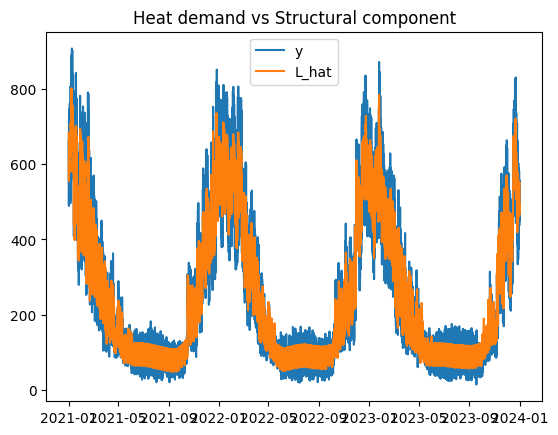

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

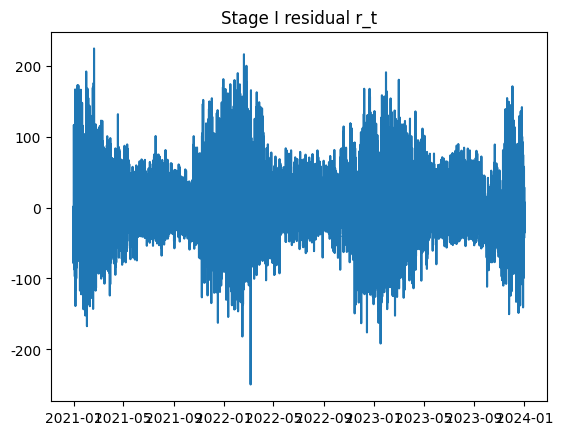

In [30]:
import matplotlib.pyplot as plt

# 1) 원본 vs 구조
plt.figure()
plt.plot(df1.index, df1["heat_demand"], label="y")
plt.plot(df1.index, df1["L_hat"], label="L_hat")
plt.legend()
plt.title("Heat demand vs Structural component")
plt.show()

# 2) 잔차
plt.figure()
plt.plot(df1.index, df1["r"])
plt.title("Stage I residual r_t")
plt.show()

In [31]:
# =========================
# Cell 1) Train+Val로 Stage I 최종 모델(final_model) 재학습
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# best_K, train_df, val_df, df1(or df1_out), build_X, Y_COL 가 이미 있다고 가정
Kd_best, Ky_best = best_K

trainval_df = pd.concat([train_df, val_df], axis=0)

X_trainval = build_X(trainval_df, Kd_best, Ky_best)
y_trainval = trainval_df[Y_COL].values.astype(float)

final_model = LinearRegression().fit(X_trainval, y_trainval)

print("final_model fitted.")
print("Best (Kd, Ky) =", best_K)


final_model fitted.
Best (Kd, Ky) = (np.int64(1), np.int64(4))


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

Max abs diff (recon vs L_hat): 3.410605131648481e-13


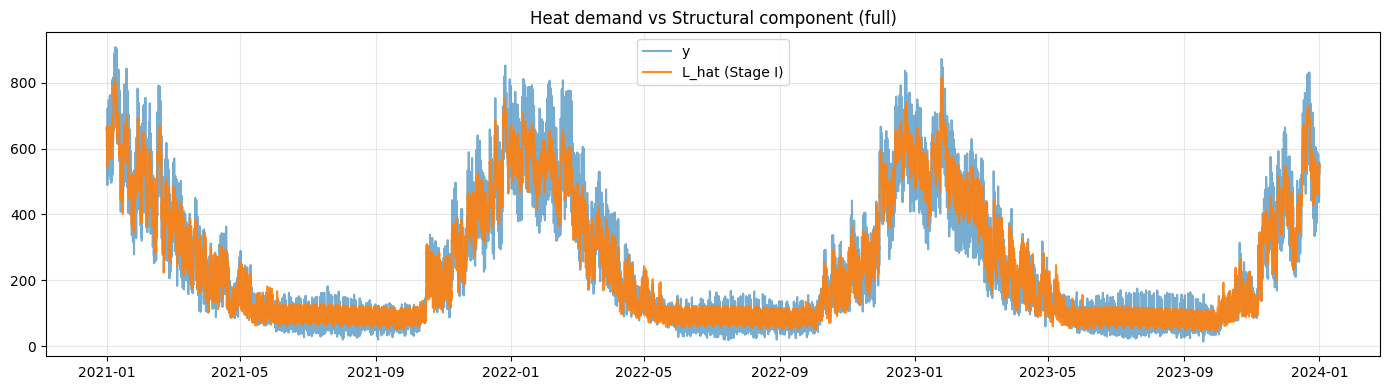

In [32]:
# =========================
# Cell 2) 전체 구간 예측(L_hat) + 성분별 기여도 분해 + residual 계산
# =========================
# df1을 전체 데이터프레임으로 사용 (네 환경에서 전체 df가 df1이면 그대로)
df_all = df1.copy()

X_all = build_X(df_all, Kd_best, Ky_best)
coef = final_model.coef_
intercept = final_model.intercept_

L_hat = intercept + X_all @ coef

# build_X 순서:
# [0]=t_hours(trend), [1]=hdh(weather), [2]=is_offday(social), [3:]=fourier(season)
trend_contrib   = X_all[:, 0] * coef[0]
weather_contrib = X_all[:, 1] * coef[1]
social_contrib  = X_all[:, 2] * coef[2]
season_contrib  = X_all[:, 3:] @ coef[3:]

# 수치 검증: 분해합 == L_hat
recon = intercept + trend_contrib + weather_contrib + social_contrib + season_contrib
print("Max abs diff (recon vs L_hat):", np.max(np.abs(recon - L_hat)))

y_all = df_all[Y_COL].values.astype(float)
resid = y_all - L_hat

# 결과 DF로 정리
df_stage1 = df_all.copy()
df_stage1["L_hat"] = L_hat
df_stage1["trend_contrib"] = trend_contrib
df_stage1["weather_contrib"] = weather_contrib
df_stage1["social_contrib"] = social_contrib
df_stage1["season_contrib"] = season_contrib
df_stage1["resid_stage1"] = resid

df_stage1[[Y_COL, "L_hat", "resid_stage1"]].head()


# =========================
# Cell 3) (1) y vs L_hat 전체 플롯
# =========================
plt.figure(figsize=(14, 4))
plt.plot(df_stage1.index, df_stage1[Y_COL], label="y", alpha=0.6)
plt.plot(df_stage1.index, df_stage1["L_hat"], label="L_hat (Stage I)", alpha=0.9)
plt.title("Heat demand vs Structural component (full)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

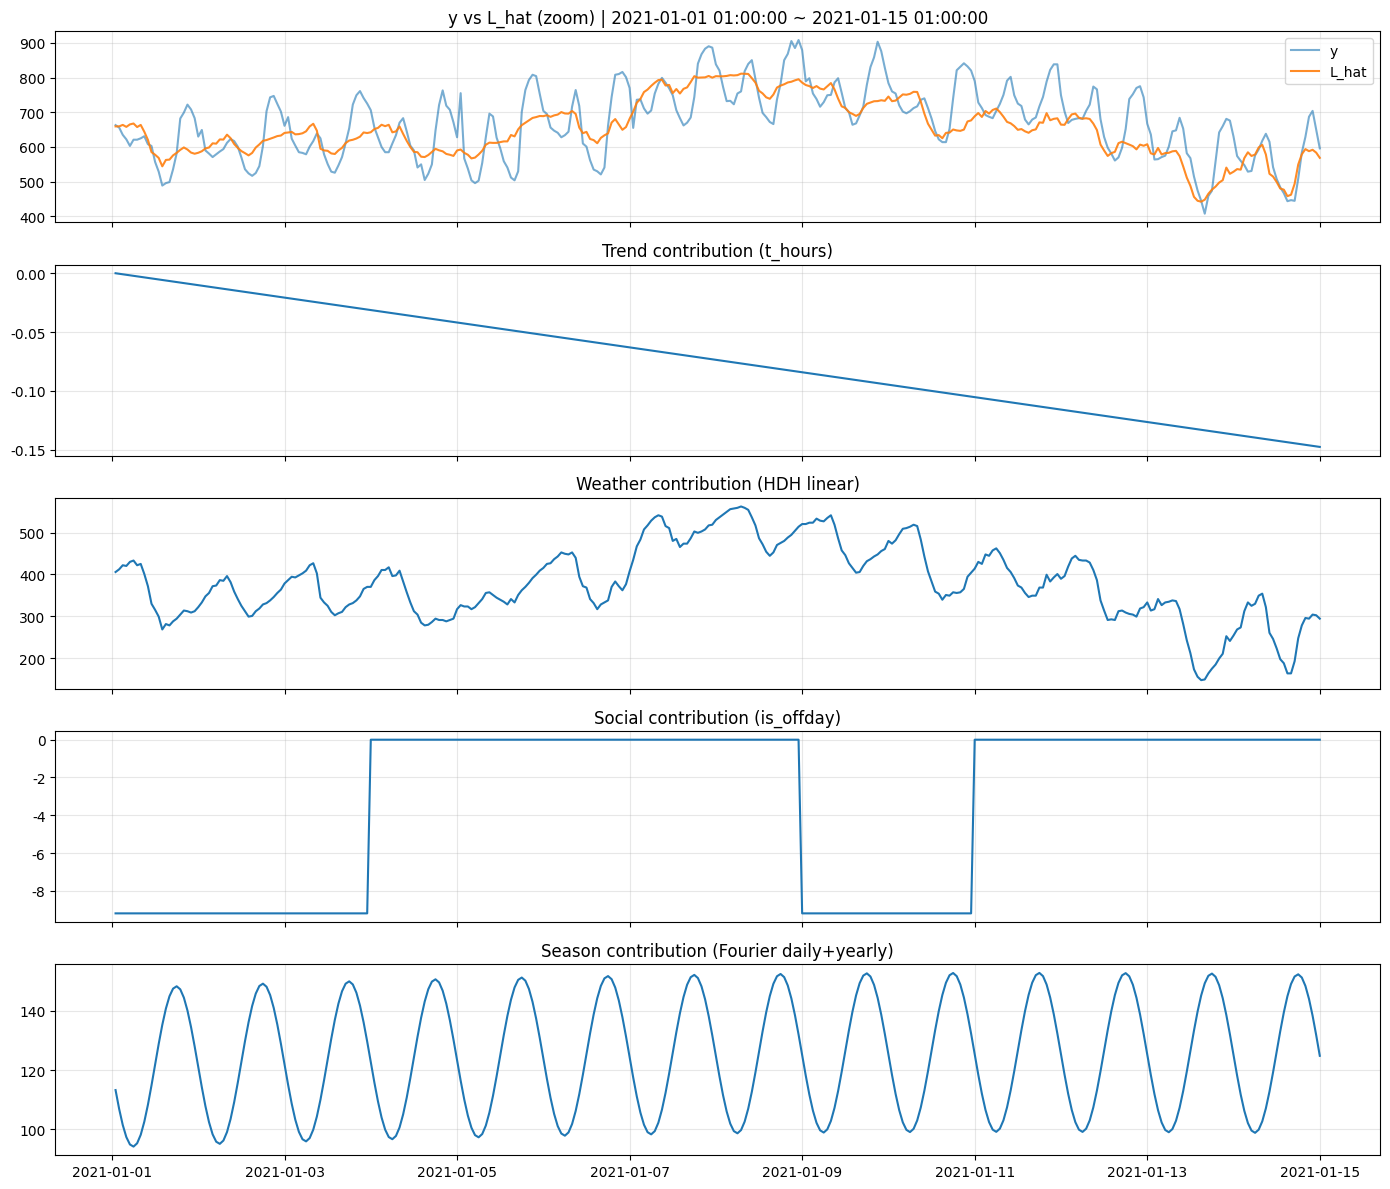

In [33]:
# =========================
# Cell 4) (2) 성분별 기여도 zoom 플롯 (원하는 기간으로 조절)
# =========================
# 기본: 2주 확대
start_dt = df_stage1.index[0]  # 필요시 test 시작 등으로 변경
end_dt = start_dt + pd.Timedelta(hours=24*14)

mask = (df_stage1.index >= start_dt) & (df_stage1.index < end_dt)
x = df_stage1.index[mask]

fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

axes[0].plot(x, df_stage1.loc[mask, Y_COL], label="y", alpha=0.6)
axes[0].plot(x, df_stage1.loc[mask, "L_hat"], label="L_hat", alpha=0.9)
axes[0].set_title(f"y vs L_hat (zoom) | {start_dt} ~ {end_dt}")
axes[0].legend()

axes[1].plot(x, df_stage1.loc[mask, "trend_contrib"])
axes[1].set_title("Trend contribution (t_hours)")

axes[2].plot(x, df_stage1.loc[mask, "weather_contrib"])
axes[2].set_title("Weather contribution (HDH linear)")

axes[3].plot(x, df_stage1.loc[mask, "social_contrib"])
axes[3].set_title("Social contribution (is_offday)")

axes[4].plot(x, df_stage1.loc[mask, "season_contrib"])
axes[4].set_title("Season contribution (Fourier daily+yearly)")

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

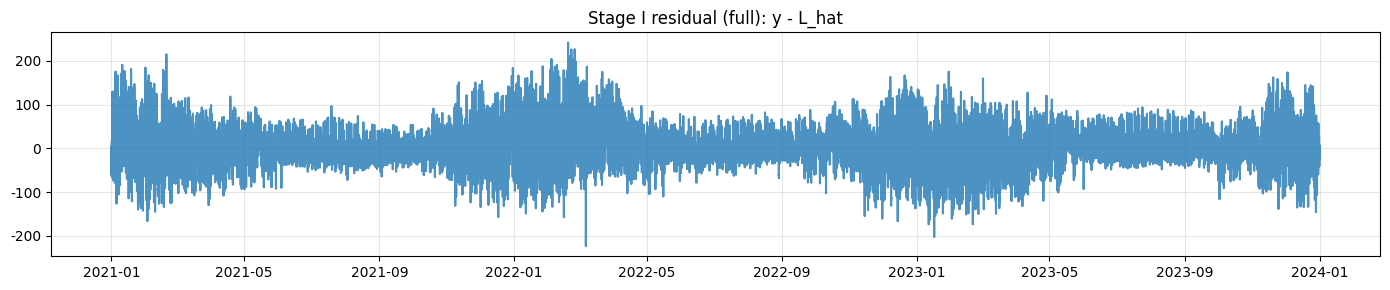

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

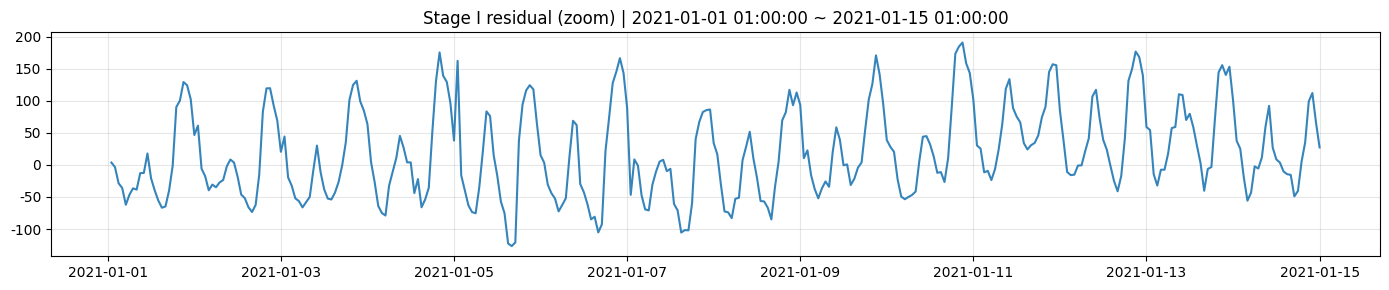

In [34]:
# =========================
# Cell 5) (3) residual 전체 + residual zoom
# =========================
plt.figure(figsize=(14, 3))
plt.plot(df_stage1.index, df_stage1["resid_stage1"], alpha=0.8)
plt.title("Stage I residual (full): y - L_hat")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# residual zoom (동일 구간)
plt.figure(figsize=(14, 3))
plt.plot(x, df_stage1.loc[mask, "resid_stage1"], alpha=0.9)
plt.title(f"Stage I residual (zoom) | {start_dt} ~ {end_dt}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2차식에 대한 전개 생성

In [37]:
import numpy as np
import pandas as pd
import random
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device


device(type='mps')

In [38]:
# 필수 컬럼 체크
req_cols = [Y_COL, "L_hat", "resid_stage1"]
for c in req_cols:
    assert c in df_stage1.columns, f"Missing column: {c}"

# 전체 길이 (df_stage1이 전체 데이터라고 가정)
N = len(df_stage1)

# 분할 인덱스 (너가 이전에 쓴 8:1:1 기준이면 train_end/val_end가 존재할 것)
# 없다면 아래처럼 재계산:
total_len = len(df_stage1)
train_end = int(total_len * 0.80)
val_end   = int(total_len * 0.90)

idx_train = np.arange(0, train_end)
idx_val   = np.arange(train_end, val_end)
idx_test  = np.arange(val_end, total_len)

r_all = df_stage1["resid_stage1"].values.astype(np.float32)
L_all = df_stage1["L_hat"].values.astype(np.float32)
y_all = df_stage1[Y_COL].values.astype(np.float32)

# residual scaler: train 구간만 fit
scaler_r = StandardScaler()
scaler_r.fit(r_all[idx_train].reshape(-1, 1))

r_all_s = scaler_r.transform(r_all.reshape(-1, 1)).reshape(-1).astype(np.float32)

print("Residual mean/std (train):", r_all[idx_train].mean(), r_all[idx_train].std())
print("Residual scaled mean/std (train):", r_all_s[idx_train].mean(), r_all_s[idx_train].std())


Residual mean/std (train): -0.67876536 48.156517
Residual scaled mean/std (train): 0.0 1.0


In [49]:
class NonOverlapSeq2SeqDataset(Dataset):
    def __init__(self, r_scaled, L_hat, y, t_indices, lookback=168, horizon=24):
        """
        t_indices: cutoff t들의 리스트/배열
          - 입력은 [t-lookback+1 ... t]
          - 출력은 [t+1 ... t+horizon]
        """
        self.r = r_scaled
        self.L_hat = L_hat
        self.y = y
        self.t_idx = np.array(t_indices, dtype=int)
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.t_idx)

    def __getitem__(self, i):
        t = self.t_idx[i]
        L = self.lookback
        H = self.horizon

        x = self.r[t-L+1 : t+1]                  # (L,)
        y_r = self.r[t+1 : t+H+1]                # (H,)  scaled residual targets

        # 재조합 평가용(옵션): 구조성분과 실제 y도 함께 반환
        L_future = self.L_hat[t+1 : t+H+1]       # (H,)
        y_future = self.y[t+1 : t+H+1]           # (H,)

        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y_r, dtype=torch.float32),
            torch.tensor(L_future, dtype=torch.float32),
            torch.tensor(y_future, dtype=torch.float32),
        )

def make_cutoffs_for_split(N, lookback, horizon, stride, start, end):
    """
    cutoff t는 [start..end) 범위에 속하되,
    t-lookback+1 >= 0, t+horizon < N을 만족해야 함.
    그리고 non-overlap용으로 t를 stride만큼 점프.
    """
    t_min = max(start + lookback - 1, lookback - 1)
    t_max = min(end - 1, N - horizon - 1)
    if t_min > t_max:
        return np.array([], dtype=int)
    return np.arange(t_min, t_max + 1, stride, dtype=int)

LOOKBACK = 168
HORIZON  = 12
STRIDE   = 12  # non-overlap

cut_train = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=0, end=train_end)
cut_val   = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=train_end, end=val_end)
cut_test  = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=val_end, end=N)

print("n_train samples:", len(cut_train))
print("n_val samples  :", len(cut_val))
print("n_test samples :", len(cut_test))

ds_train = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_train, LOOKBACK, HORIZON)
ds_val   = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_val,   LOOKBACK, HORIZON)
ds_test  = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_test,  LOOKBACK, HORIZON)


n_train samples: 1738
n_val samples  : 206
n_test samples : 205


In [50]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.decoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x, horizon=24, teacher_forcing_ratio=0.0, y_tf=None):
        """
        x: (B, L) scaled residual history
        y_tf: (B, H) scaled residual targets (for teacher forcing)
        return: yhat (B, H)
        """
        B, L = x.shape
        x_enc = x.unsqueeze(-1)  # (B, L, 1)

        _, (h, c) = self.encoder(x_enc)  # use final state

        # decoder input: start token = last observed residual
        dec_in = x[:, -1].unsqueeze(-1).unsqueeze(-1)  # (B, 1, 1)

        outputs = []
        h_dec, c_dec = h, c
        for t in range(horizon):
            dec_out, (h_dec, c_dec) = self.decoder(dec_in, (h_dec, c_dec))
            y_step = self.out(dec_out)  # (B, 1, 1)
            outputs.append(y_step.squeeze(-1))  # (B, 1)

            use_tf = (y_tf is not None) and (random.random() < teacher_forcing_ratio)
            if use_tf:
                dec_in = y_tf[:, t].unsqueeze(-1).unsqueeze(-1)  # (B,1,1)
            else:
                dec_in = y_step.detach()

        yhat = torch.cat(outputs, dim=1)  # (B, H)
        return yhat


In [51]:
def run_epoch(model, loader, optimizer=None, teacher_forcing_ratio=0.0):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    n = 0
    loss_fn = nn.MSELoss()

    for x, y_r, _, _ in loader:
        x = x.to(device)
        y_r = y_r.to(device)

        if train_mode:
            optimizer.zero_grad()

        yhat = model(x, horizon=y_r.shape[1], teacher_forcing_ratio=teacher_forcing_ratio, y_tf=y_r)
        loss = loss_fn(yhat, y_r)

        if train_mode:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate_recombined(model, loader):
    """
    residual 예측(D_hat) + 구조성분(L_hat_future)을 더해 y_hat 평가
    """
    model.eval()
    y_true_all = []
    y_pred_all = []

    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0, y_tf=None)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()

        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(yhat_r_scaled.reshape(-1,1)).reshape(yhat_r_scaled.shape).astype(np.float32)

        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)

        yhat = L_future + yhat_r

        y_true_all.append(y_future.reshape(-1))
        y_pred_all.append(yhat.reshape(-1))

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    mse = mean_squared_error(y_true_all, y_pred_all)
    return mse


In [52]:
def run_epoch(model, loader, optimizer=None, teacher_forcing_ratio=0.0):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    n = 0
    loss_fn = nn.MSELoss()

    for x, y_r, _, _ in loader:
        x = x.to(device)
        y_r = y_r.to(device)

        if train_mode:
            optimizer.zero_grad()

        yhat = model(x, horizon=y_r.shape[1], teacher_forcing_ratio=teacher_forcing_ratio, y_tf=y_r)
        loss = loss_fn(yhat, y_r)

        if train_mode:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate_recombined(model, loader):
    """
    residual 예측(D_hat) + 구조성분(L_hat_future)을 더해 y_hat 평가
    """
    model.eval()
    y_true_all = []
    y_pred_all = []

    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0, y_tf=None)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()

        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(yhat_r_scaled.reshape(-1,1)).reshape(yhat_r_scaled.shape).astype(np.float32)

        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)

        yhat = L_future + yhat_r

        y_true_all.append(y_future.reshape(-1))
        y_pred_all.append(yhat.reshape(-1))

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    mse = mean_squared_error(y_true_all, y_pred_all)
    return mse


In [53]:
@dataclass
class HP:
    hidden_size: int
    num_layers: int
    dropout: float
    lr: float
    batch_size: int
    teacher_forcing: float
    max_epochs: int
    patience: int

def sample_hp():
    hidden_size = random.choice([32, 64, 96, 128, 192])
    num_layers  = random.choice([1, 2, 3])
    dropout     = random.choice([0.0, 0.1, 0.2, 0.3])
    lr          = 10 ** random.uniform(-4.0, -2.5)  # ~[1e-4, 3e-3]
    batch_size  = random.choice([16, 32, 64])
    teacher_forcing = random.choice([0.0, 0.2, 0.4, 0.6])
    max_epochs  = 40
    patience    = 6
    return HP(hidden_size, num_layers, dropout, lr, batch_size, teacher_forcing, max_epochs, patience)

def fit_one_trial(hp: HP, trial_id=0):
    train_loader = DataLoader(ds_train, batch_size=hp.batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(ds_val,   batch_size=hp.batch_size, shuffle=False, drop_last=False)

    model = Seq2SeqLSTM(hidden_size=hp.hidden_size, num_layers=hp.num_layers, dropout=hp.dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hp.lr)

    best_val = float("inf")
    best_state = None
    bad = 0

    hist = []
    for epoch in range(1, hp.max_epochs + 1):
        tr_loss = run_epoch(model, train_loader, optimizer=optimizer, teacher_forcing_ratio=hp.teacher_forcing)
        # val: residual-space loss도 볼 수 있지만, 우리는 최종 목표인 y-space MSE를 기준으로 선택
        val_mse_y = evaluate_recombined(model, val_loader)

        hist.append((epoch, tr_loss, val_mse_y))

        if val_mse_y < best_val:
            best_val = val_mse_y
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= hp.patience:
                break

    # load best
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val, pd.DataFrame(hist, columns=["epoch", "train_loss_resid_scaled", "val_mse_y"])

N_TRIALS = 20  # 필요 시 늘리세요(시간/자원에 맞게)
trial_records = []
best_overall = float("inf")
best_hp = None
best_model = None
best_hist = None

for i in range(N_TRIALS):
    hp = sample_hp()
    model_i, val_mse_y, hist_df = fit_one_trial(hp, trial_id=i)

    rec = {
        "trial": i,
        "val_mse_y": val_mse_y,
        **hp.__dict__
    }
    trial_records.append(rec)

    print(f"[trial {i}] val_mse_y={val_mse_y:.4f} | hp={hp}")

    if val_mse_y < best_overall:
        best_overall = val_mse_y
        best_hp = hp
        best_model = model_i
        best_hist = hist_df

results_hp = pd.DataFrame(trial_records).sort_values("val_mse_y")
results_hp.head(10)


# train+val 합친 데이터셋 구성(컷오프도 다시 만들기)
cut_trainval = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=0, end=val_end)
ds_trainval = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_trainval, LOOKBACK, HORIZON)

trainval_loader = DataLoader(ds_trainval, batch_size=best_hp.batch_size, shuffle=True, drop_last=False)
test_loader     = DataLoader(ds_test,     batch_size=best_hp.batch_size, shuffle=False, drop_last=False)

model_final = Seq2SeqLSTM(hidden_size=best_hp.hidden_size, num_layers=best_hp.num_layers, dropout=best_hp.dropout).to(device)
opt = torch.optim.Adam(model_final.parameters(), lr=best_hp.lr)

best_state = None
best_trainval = float("inf")
bad = 0

for epoch in range(1, best_hp.max_epochs + 1):
    tr_loss = run_epoch(model_final, trainval_loader, optimizer=opt, teacher_forcing_ratio=best_hp.teacher_forcing)
    # 학습 중간 체크용(선택): trainval에서의 y MSE를 구하면 시간이 늘어납니다.
    # 여기서는 단순히 tr_loss로만 모니터링하거나, val을 따로 유지해도 됨.
    if tr_loss < best_trainval:
        best_trainval = tr_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model_final.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= best_hp.patience:
            break

if best_state is not None:
    model_final.load_state_dict(best_state)

test_mse_y = evaluate_recombined(model_final, test_loader)
print("Best HP:", best_hp)
print("Test MSE (y-space, recombined) =", test_mse_y)

[trial 0] val_mse_y=383.3135 | hp=HP(hidden_size=128, num_layers=3, dropout=0.2, lr=0.0005168875706819556, batch_size=32, teacher_forcing=0.2, max_epochs=40, patience=6)
[trial 1] val_mse_y=315.8381 | hp=HP(hidden_size=192, num_layers=3, dropout=0.1, lr=0.0004118579320972047, batch_size=16, teacher_forcing=0.4, max_epochs=40, patience=6)
[trial 2] val_mse_y=973.0146 | hp=HP(hidden_size=128, num_layers=1, dropout=0.0, lr=0.0002523283515699183, batch_size=64, teacher_forcing=0.2, max_epochs=40, patience=6)
[trial 3] val_mse_y=968.8427 | hp=HP(hidden_size=64, num_layers=1, dropout=0.0, lr=0.0001870770531147685, batch_size=32, teacher_forcing=0.6, max_epochs=40, patience=6)
[trial 4] val_mse_y=386.2230 | hp=HP(hidden_size=64, num_layers=3, dropout=0.3, lr=0.0002894599275058682, batch_size=64, teacher_forcing=0.2, max_epochs=40, patience=6)
[trial 5] val_mse_y=354.8458 | hp=HP(hidden_size=64, num_layers=2, dropout=0.3, lr=0.0005309687962858361, batch_size=16, teacher_forcing=0.6, max_epochs

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

Test samples: 205 blocks × 12 hours = 2460 predictions

=== Test Set Performance ===
MSE  : 1087.0236
RMSE : 32.9700
MAE  : 25.5449
MAPE : 12.61%
R²   : 0.9704


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


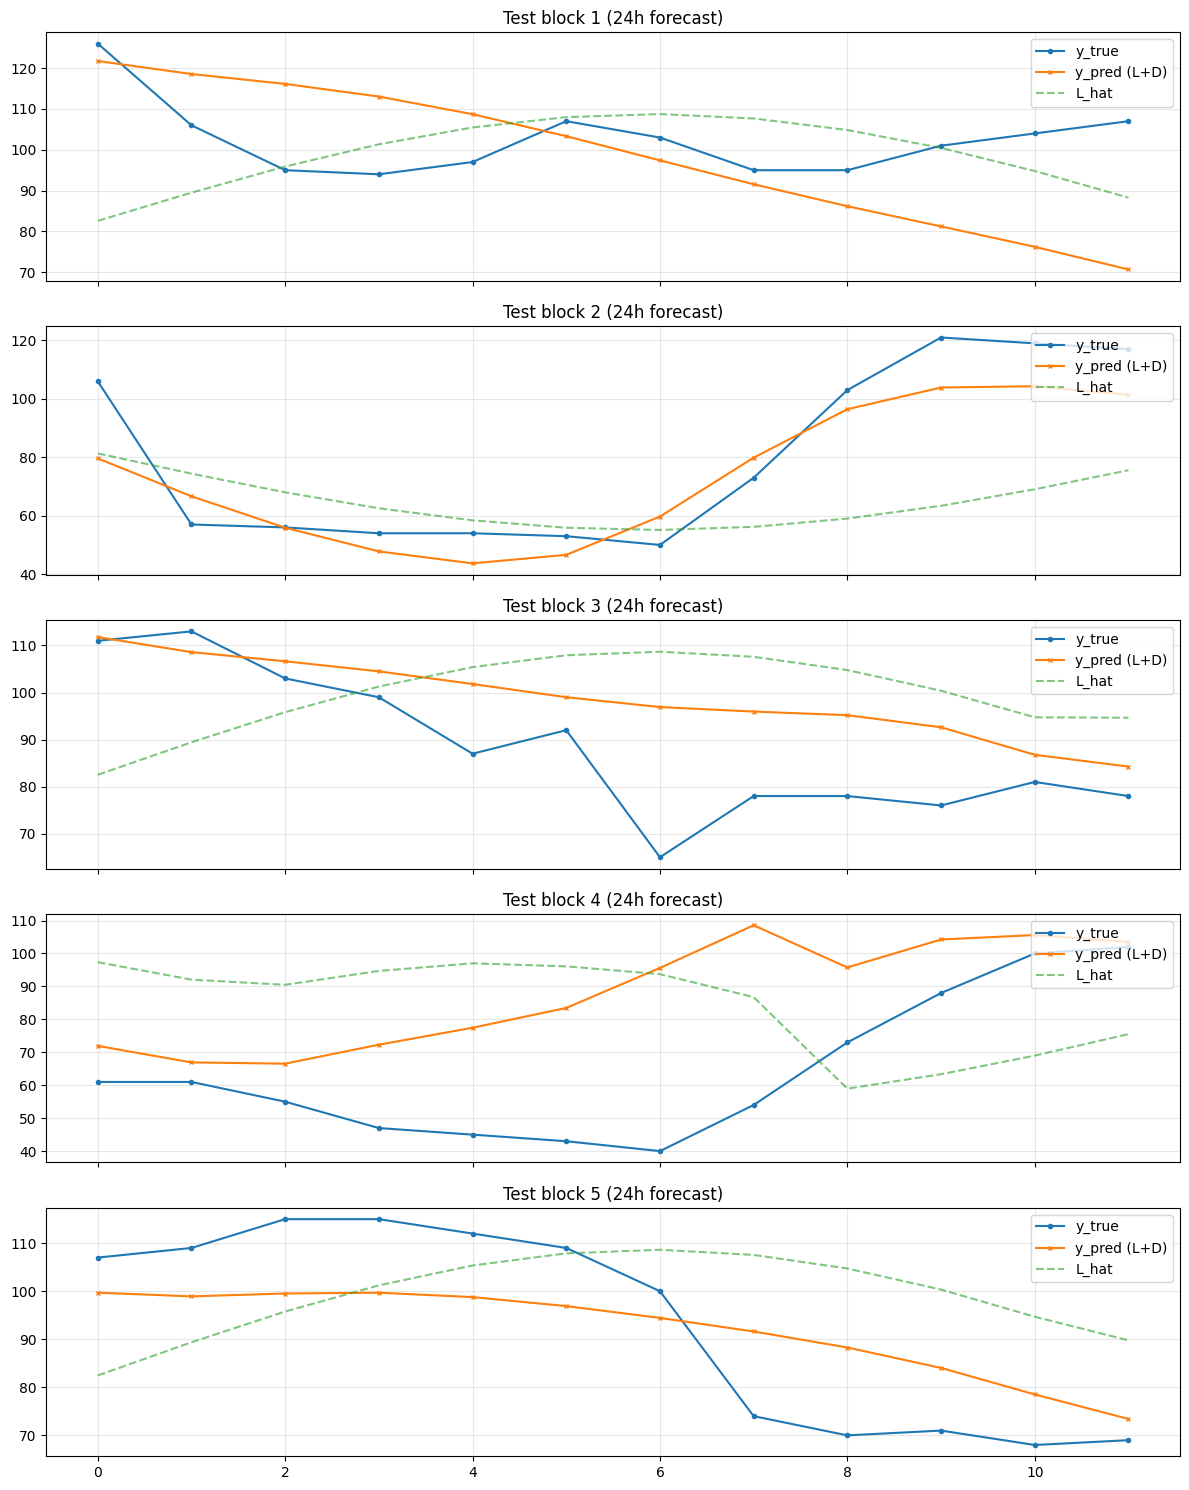

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

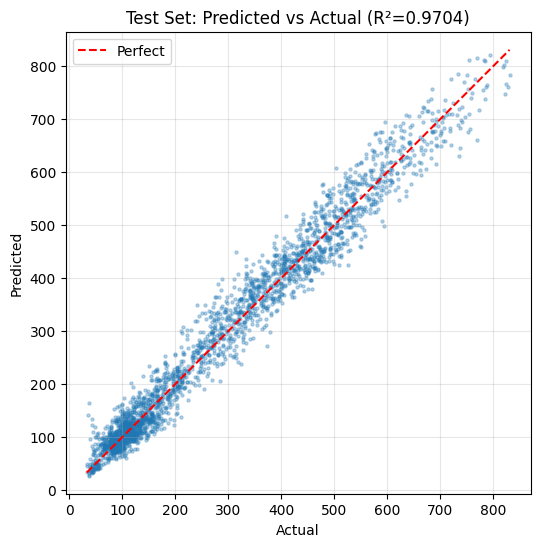

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

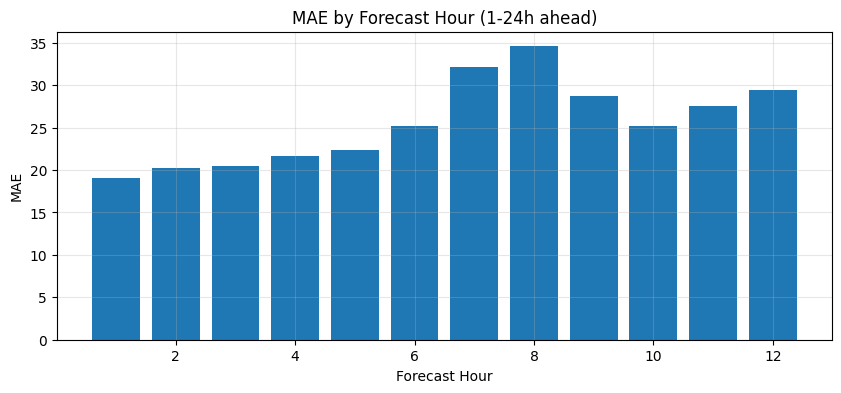

In [54]:
@torch.no_grad()
def evaluate_all_test(model, loader, scaler_r):
    """전체 test set에 대한 예측 및 평가"""
    model.eval()
    
    all_y_true = []
    all_y_pred = []
    all_L_hat = []
    all_D_hat = []
    
    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()
        
        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(
            yhat_r_scaled.reshape(-1, 1)
        ).reshape(yhat_r_scaled.shape).astype(np.float32)
        
        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)
        
        yhat = L_future + yhat_r
        
        all_y_true.append(y_future)
        all_y_pred.append(yhat)
        all_L_hat.append(L_future)
        all_D_hat.append(yhat_r)
    
    return (
        np.concatenate(all_y_true, axis=0),
        np.concatenate(all_y_pred, axis=0),
        np.concatenate(all_L_hat, axis=0),
        np.concatenate(all_D_hat, axis=0),
    )

# 전체 test set 예측
y_true_all, y_pred_all, L_all_test, D_all_test = evaluate_all_test(model_final, test_loader, scaler_r)

print(f"Test samples: {len(y_true_all)} blocks × {y_true_all.shape[1]} hours = {y_true_all.size} predictions")

# 메트릭 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true_flat = y_true_all.flatten()
y_pred_flat = y_pred_all.flatten()

mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100
r2 = r2_score(y_true_flat, y_pred_flat)

print(f"\n=== Test Set Performance ===")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

# 시각화 1: 전체 예측 vs 실제 (첫 N개 블록)
n_blocks_to_show = min(5, len(y_true_all))

fig, axes = plt.subplots(n_blocks_to_show, 1, figsize=(12, 3*n_blocks_to_show), sharex=True)
for i in range(n_blocks_to_show):
    ax = axes[i] if n_blocks_to_show > 1 else axes
    ax.plot(y_true_all[i], label="y_true", marker='o', markersize=3)
    ax.plot(y_pred_all[i], label="y_pred (L+D)", marker='x', markersize=3)
    ax.plot(L_all_test[i], label="L_hat", alpha=0.6, linestyle='--')
    ax.legend(loc='upper right')
    ax.set_title(f"Test block {i+1} (24h forecast)")
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 시각화 2: Scatter plot (예측 vs 실제)
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=5)
plt.plot([y_true_flat.min(), y_true_flat.max()], 
         [y_true_flat.min(), y_true_flat.max()], 'r--', label='Perfect')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test Set: Predicted vs Actual (R²={r2:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# 시각화 3: 시간별 에러 분포 (24시간 중 어느 시점이 어려운지)
hourly_mae = np.mean(np.abs(y_true_all - y_pred_all), axis=0)
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(hourly_mae)+1), hourly_mae)
plt.xlabel("Forecast Hour")
plt.ylabel("MAE")
plt.title("MAE by Forecast Hour (1-24h ahead)")
plt.grid(True, alpha=0.3)
plt.show()

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

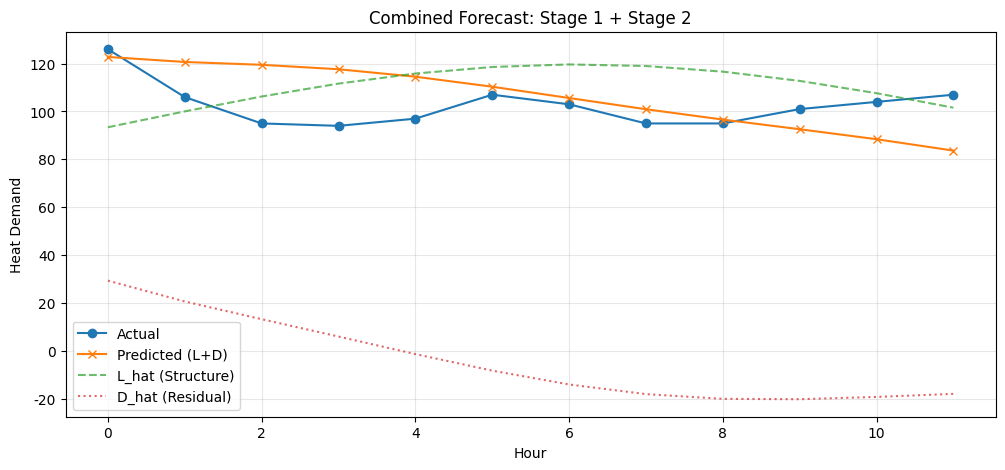

RMSE: 14.74
MAE:  12.04


In [55]:
class CombinedForecaster:
    """Stage 1 (ElasticNet) + Stage 2 (LSTM) 통합 예측기"""
    
    def __init__(self, stage1_model, stage1_scaler, stage2_model, stage2_scaler, 
                 lookback=168, horizon=24):
        self.stage1_model = stage1_model      # ElasticNet
        self.stage1_scaler = stage1_scaler    # StandardScaler for X
        self.stage2_model = stage2_model      # Seq2SeqLSTM
        self.stage2_scaler = stage2_scaler    # StandardScaler for residuals
        self.lookback = lookback
        self.horizon = horizon
    
    def predict(self, X_future, past_residuals):
        """
        Args:
            X_future: 미래 horizon 시점의 피처 (DataFrame, shape: [horizon, n_features])
                      - t_hours, hdh, is_offday, Fourier terms 등
            past_residuals: 과거 lookback 시점의 잔차 (array, shape: [lookback,])
        
        Returns:
            y_hat: 최종 예측 (L_hat + D_hat)
            L_hat: 구조 성분 예측
            D_hat: 잔차 예측
        """
        # Stage 1: 구조 성분 예측
        X_scaled = self.stage1_scaler.transform(X_future.values)
        L_hat = self.stage1_model.predict(X_scaled)
        
        # Stage 2: 잔차 예측
        r_scaled = self.stage2_scaler.transform(
            past_residuals.reshape(-1, 1)
        ).reshape(-1).astype(np.float32)
        
        x = torch.tensor(r_scaled, dtype=torch.float32).unsqueeze(0).to(device)  # (1, lookback)
        
        self.stage2_model.eval()
        with torch.no_grad():
            D_hat_scaled = self.stage2_model(x, horizon=self.horizon, teacher_forcing_ratio=0.0)
            D_hat_scaled = D_hat_scaled.cpu().numpy()
        
        D_hat = self.stage2_scaler.inverse_transform(
            D_hat_scaled.reshape(-1, 1)
        ).reshape(-1).astype(np.float32)
        
        # 최종 예측
        y_hat = L_hat + D_hat
        
        return y_hat, L_hat, D_hat


# 통합 모델 생성
forecaster = CombinedForecaster(
    stage1_model=model,           # ElasticNet
    stage1_scaler=scaler,         # Stage 1 StandardScaler
    stage2_model=model_final,     # Seq2SeqLSTM  
    stage2_scaler=scaler_r,       # Stage 2 StandardScaler (residuals)
    lookback=LOOKBACK,
    horizon=HORIZON
)

# 예측 예시: test set 첫 번째 구간
# 1) 미래 24시간의 X 피처 준비
test_start_idx = val_end_idx + LOOKBACK
X_future = X.iloc[test_start_idx : test_start_idx + HORIZON]

# 2) 과거 168시간의 잔차
past_residuals = df1["r"].values[test_start_idx - LOOKBACK : test_start_idx]

# 3) 예측
y_hat, L_hat, D_hat = forecaster.predict(X_future, past_residuals)

# 4) 실제값과 비교
y_true = df1["heat_demand"].values[test_start_idx : test_start_idx + HORIZON]

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(y_true, label="Actual", marker='o')
plt.plot(y_hat, label="Predicted (L+D)", marker='x')
plt.plot(L_hat, label="L_hat (Structure)", linestyle='--', alpha=0.7)
plt.plot(D_hat, label="D_hat (Residual)", linestyle=':', alpha=0.7)
plt.legend()
plt.title("Combined Forecast: Stage 1 + Stage 2")
plt.xlabel("Hour")
plt.ylabel("Heat Demand")
plt.grid(True, alpha=0.3)
plt.show()

print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_hat)):.2f}")
print(f"MAE:  {mean_absolute_error(y_true, y_hat):.2f}")

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

Test blocks: 205
Total predictions: 2460

=== Test Set Performance (Combined Model) ===
MSE  : 1088.0832
RMSE : 32.9861
MAE  : 25.7489
MAPE : 13.17%
R²   : 0.9703


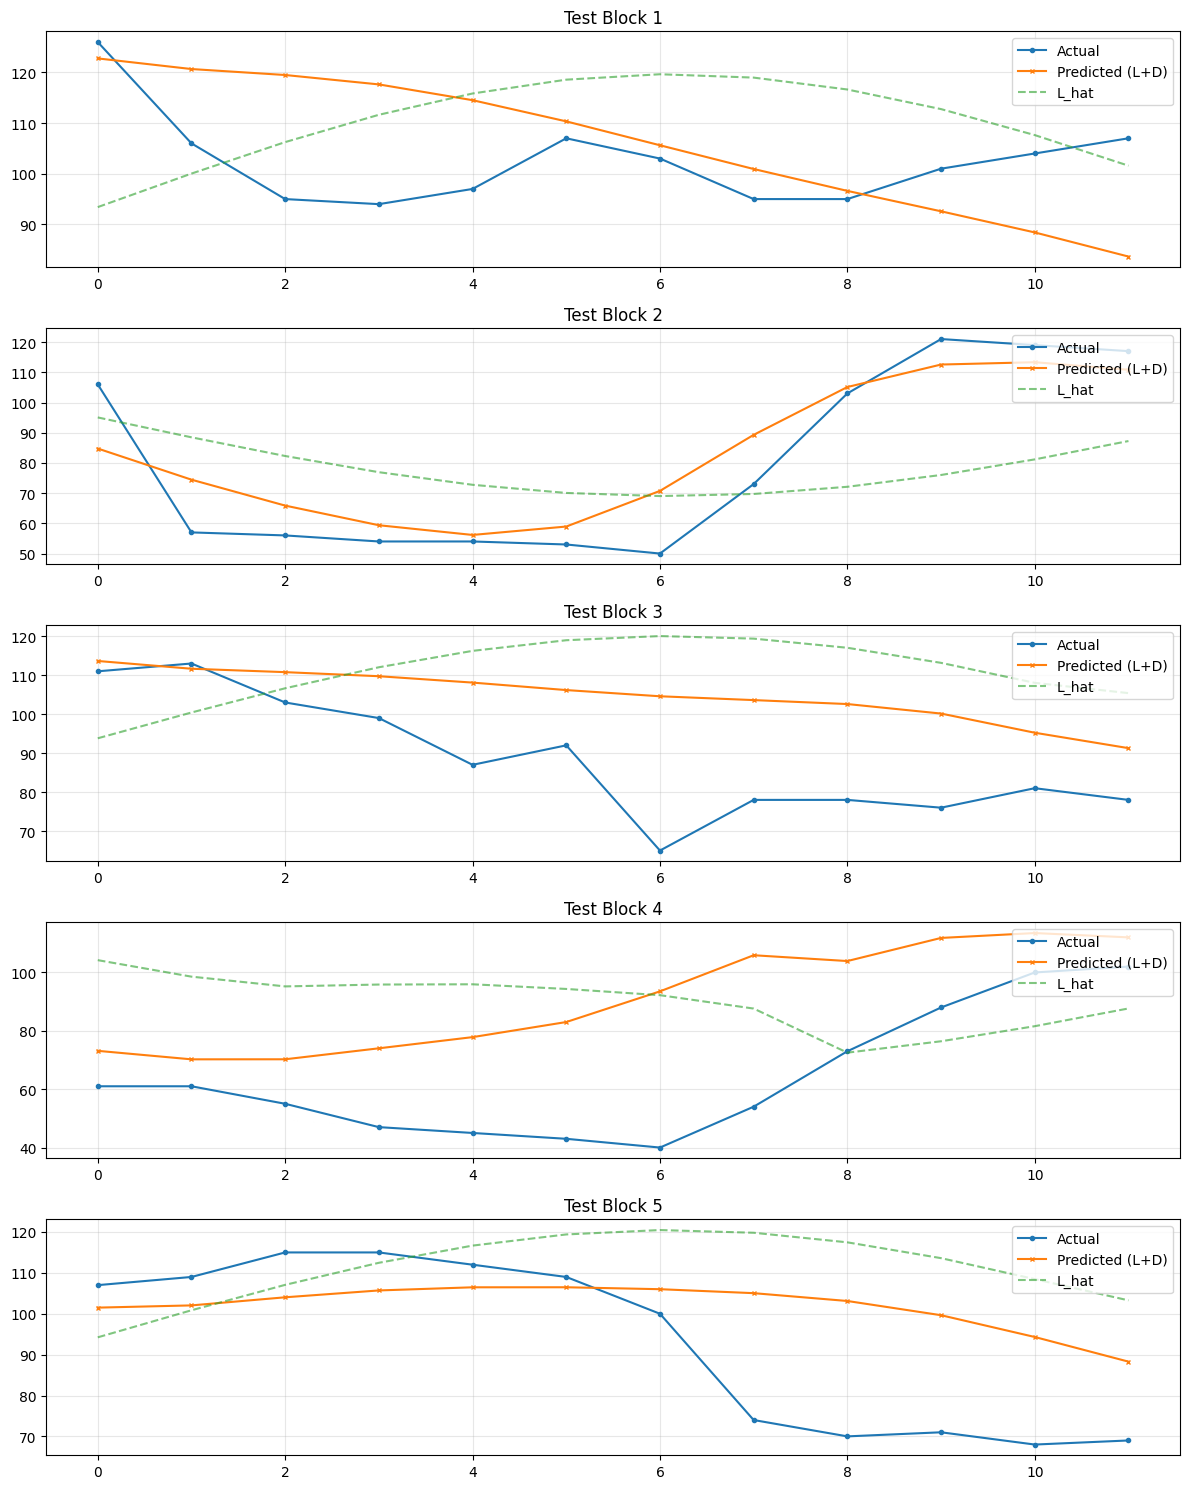

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

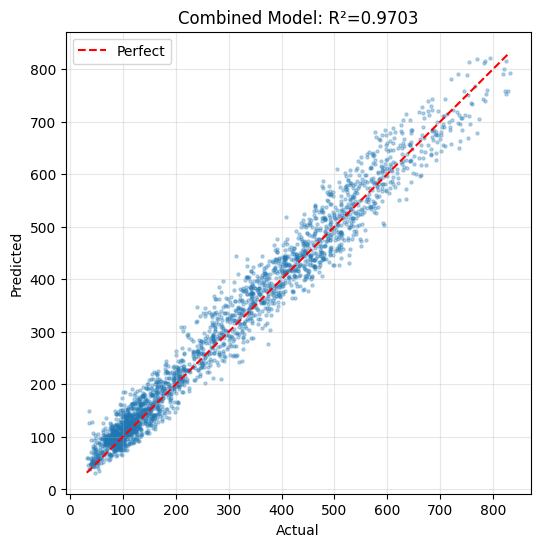

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

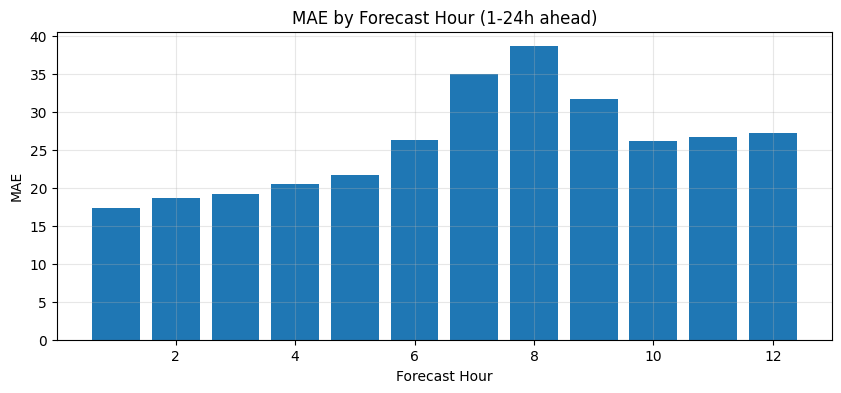

In [56]:
class CombinedForecaster:
    """Stage 1 (ElasticNet) + Stage 2 (LSTM) 통합 예측기"""
    
    def __init__(self, stage1_model, stage1_scaler, stage2_model, stage2_scaler, 
                 lookback=168, horizon=12):
        self.stage1_model = stage1_model
        self.stage1_scaler = stage1_scaler
        self.stage2_model = stage2_model
        self.stage2_scaler = stage2_scaler
        self.lookback = lookback
        self.horizon = horizon
    
    def predict(self, X_future, past_residuals):
        # Stage 1: 구조 성분 예측
        X_scaled = self.stage1_scaler.transform(X_future.values)
        L_hat = self.stage1_model.predict(X_scaled)
        
        # Stage 2: 잔차 예측
        r_scaled = self.stage2_scaler.transform(
            past_residuals.reshape(-1, 1)
        ).reshape(-1).astype(np.float32)
        
        x = torch.tensor(r_scaled, dtype=torch.float32).unsqueeze(0).to(device)
        
        self.stage2_model.eval()
        with torch.no_grad():
            D_hat_scaled = self.stage2_model(x, horizon=self.horizon, teacher_forcing_ratio=0.0)
            D_hat_scaled = D_hat_scaled.cpu().numpy().flatten()
        
        D_hat = self.stage2_scaler.inverse_transform(
            D_hat_scaled.reshape(-1, 1)
        ).flatten().astype(np.float32)
        
        y_hat = L_hat + D_hat
        return y_hat, L_hat, D_hat


# 통합 모델 생성
forecaster = CombinedForecaster(
    stage1_model=model,
    stage1_scaler=scaler,
    stage2_model=model_final,
    stage2_scaler=scaler_r,
    lookback=LOOKBACK,
    horizon=HORIZON
)

# ========================================
# 전체 Test Set 평가 (Non-overlap)
# ========================================
test_start = val_end_idx  # test 시작 인덱스
test_end = len(df1)
stride = HORIZON  # non-overlap

all_y_true = []
all_y_pred = []
all_L_hat = []
all_D_hat = []

# non-overlap 방식으로 전체 test 구간 순회
t = test_start + LOOKBACK  # 첫 예측 시점 (lookback 이후부터)

while t + HORIZON <= test_end:
    # 미래 24시간의 X 피처
    X_future = X.iloc[t : t + HORIZON]
    
    # 과거 168시간의 잔차
    past_residuals = df1["r"].values[t - LOOKBACK : t]
    
    # 예측
    y_hat, L_hat, D_hat = forecaster.predict(X_future, past_residuals)
    
    # 실제값
    y_true = df1["heat_demand"].values[t : t + HORIZON]
    
    all_y_true.append(y_true)
    all_y_pred.append(y_hat)
    all_L_hat.append(L_hat)
    all_D_hat.append(D_hat)
    
    t += stride  # non-overlap

# numpy 배열로 변환
all_y_true = np.array(all_y_true)  # (n_blocks, 24)
all_y_pred = np.array(all_y_pred)
all_L_hat = np.array(all_L_hat)
all_D_hat = np.array(all_D_hat)

print(f"Test blocks: {len(all_y_true)}")
print(f"Total predictions: {all_y_true.size}")

# ========================================
# 메트릭 계산
# ========================================
y_true_flat = all_y_true.flatten()
y_pred_flat = all_y_pred.flatten()

mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100
r2 = r2_score(y_true_flat, y_pred_flat)

print(f"\n=== Test Set Performance (Combined Model) ===")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

# ========================================
# 시각화 1: 첫 N개 블록
# ========================================
n_blocks_show = min(5, len(all_y_true))
fig, axes = plt.subplots(n_blocks_show, 1, figsize=(12, 3*n_blocks_show))

for i in range(n_blocks_show):
    ax = axes[i] if n_blocks_show > 1 else axes
    ax.plot(all_y_true[i], label="Actual", marker='o', markersize=3)
    ax.plot(all_y_pred[i], label="Predicted (L+D)", marker='x', markersize=3)
    ax.plot(all_L_hat[i], label="L_hat", linestyle='--', alpha=0.6)
    ax.legend(loc='upper right')
    ax.set_title(f"Test Block {i+1}")
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ========================================
# 시각화 2: Scatter plot
# ========================================
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=5)
lims = [min(y_true_flat.min(), y_pred_flat.min()), 
        max(y_true_flat.max(), y_pred_flat.max())]
plt.plot(lims, lims, 'r--', label='Perfect')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Combined Model: R²={r2:.4f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ========================================
# 시각화 3: 시간별 MAE
# ========================================
hourly_mae = np.mean(np.abs(all_y_true - all_y_pred), axis=0)
plt.figure(figsize=(10, 4))
plt.bar(range(1, HORIZON+1), hourly_mae)
plt.xlabel("Forecast Hour")
plt.ylabel("MAE")
plt.title("MAE by Forecast Hour (1-24h ahead)")
plt.grid(True, alpha=0.3)
plt.show()

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

Test predictions: 2460 hours
Test period: 2023-09-20 12:00:00 ~ 2023-12-31 23:00:00

       TEST SET PERFORMANCE (Combined Model)
MSE      : 1,088.08
RMSE     : 32.99
MAE      : 25.75
MAPE     : 13.17%
sMAPE    : 11.91%
R²       : 0.9703
nRMSE    : 4.13% (of range)
CV(RMSE) : 11.33% (of mean)
Max Error: 129.63 at 2023-12-05 18:00:00


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

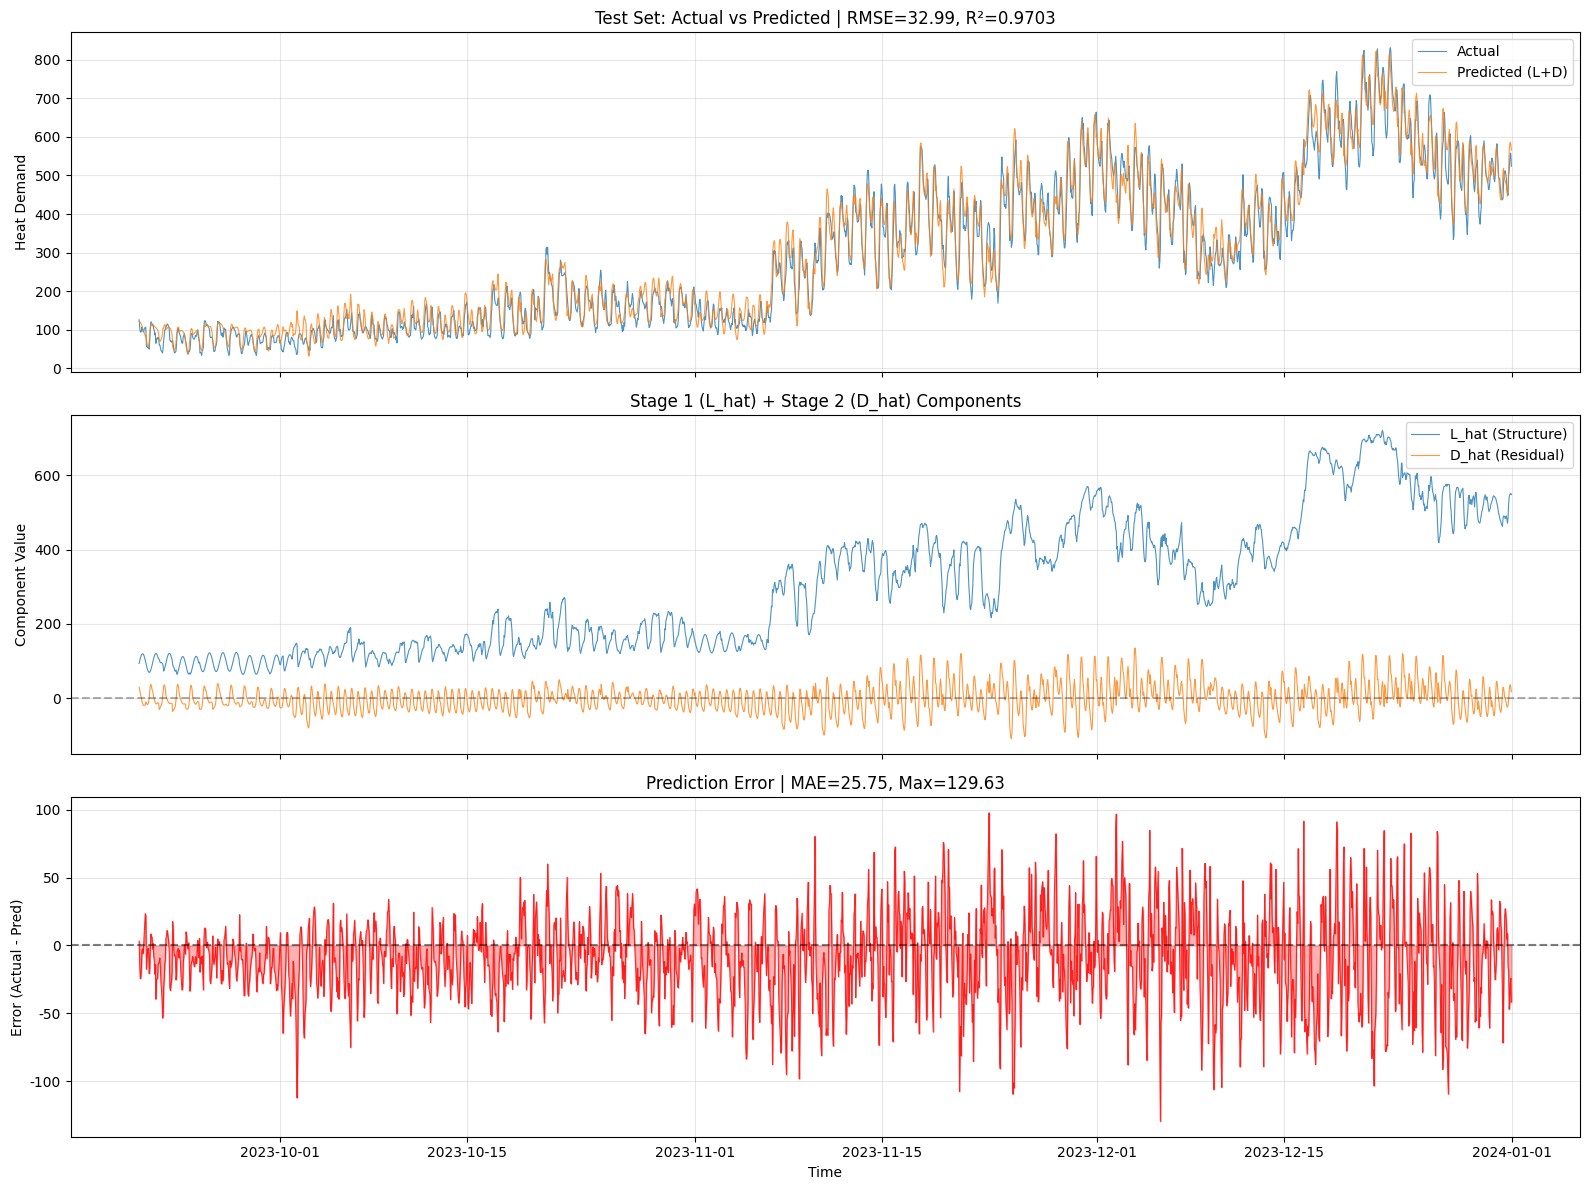

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

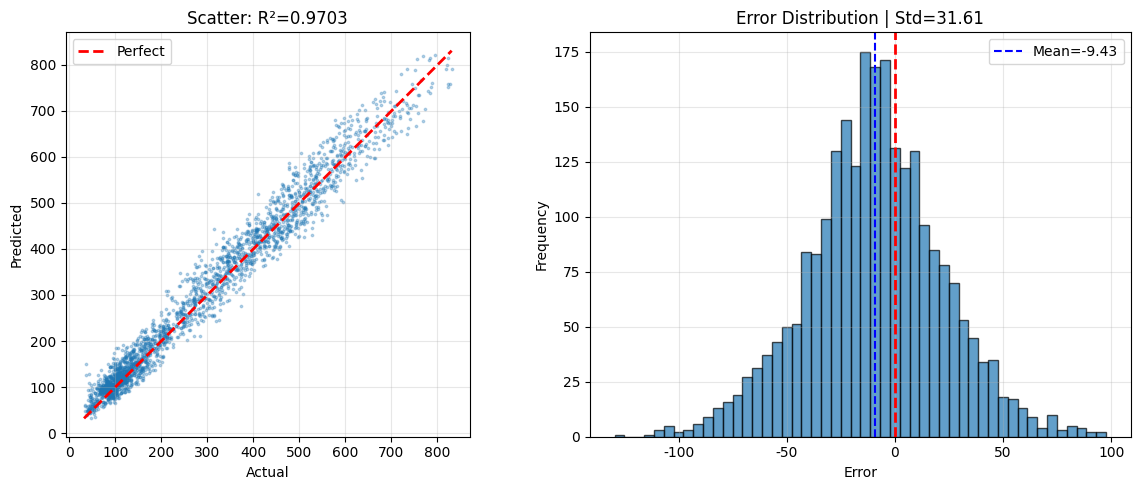

In [57]:
class CombinedForecaster:
    """Stage 1 (ElasticNet) + Stage 2 (LSTM) 통합 예측기"""
    
    def __init__(self, stage1_model, stage1_scaler, stage2_model, stage2_scaler, 
                 lookback=168, horizon=24):
        self.stage1_model = stage1_model
        self.stage1_scaler = stage1_scaler
        self.stage2_model = stage2_model
        self.stage2_scaler = stage2_scaler
        self.lookback = lookback
        self.horizon = horizon
    
    def predict(self, X_future, past_residuals):
        X_scaled = self.stage1_scaler.transform(X_future.values)
        L_hat = self.stage1_model.predict(X_scaled)
        
        r_scaled = self.stage2_scaler.transform(
            past_residuals.reshape(-1, 1)
        ).reshape(-1).astype(np.float32)
        
        x = torch.tensor(r_scaled, dtype=torch.float32).unsqueeze(0).to(device)
        
        self.stage2_model.eval()
        with torch.no_grad():
            D_hat_scaled = self.stage2_model(x, horizon=self.horizon, teacher_forcing_ratio=0.0)
            D_hat_scaled = D_hat_scaled.cpu().numpy().flatten()
        
        D_hat = self.stage2_scaler.inverse_transform(
            D_hat_scaled.reshape(-1, 1)
        ).flatten().astype(np.float32)
        
        y_hat = L_hat + D_hat
        return y_hat, L_hat, D_hat


# 통합 모델 생성
forecaster = CombinedForecaster(
    stage1_model=model,
    stage1_scaler=scaler,
    stage2_model=model_final,
    stage2_scaler=scaler_r,
    lookback=LOOKBACK,
    horizon=HORIZON
)

# ========================================
# 전체 Test Set 평가 (Non-overlap)
# ========================================
test_start = val_end_idx
test_end = len(df1)
stride = HORIZON

all_y_true = []
all_y_pred = []
all_L_hat = []
all_D_hat = []
all_indices = []  # 시간 인덱스 저장

t = test_start + LOOKBACK

while t + HORIZON <= test_end:
    X_future = X.iloc[t : t + HORIZON]
    past_residuals = df1["r"].values[t - LOOKBACK : t]
    
    y_hat, L_hat, D_hat = forecaster.predict(X_future, past_residuals)
    y_true = df1["heat_demand"].values[t : t + HORIZON]
    
    all_y_true.extend(y_true)
    all_y_pred.extend(y_hat)
    all_L_hat.extend(L_hat)
    all_D_hat.extend(D_hat)
    all_indices.extend(df1.index[t : t + HORIZON].tolist())
    
    t += stride

# numpy/series 변환
y_true_all = np.array(all_y_true)
y_pred_all = np.array(all_y_pred)
L_hat_all = np.array(all_L_hat)
D_hat_all = np.array(all_D_hat)
time_index = pd.DatetimeIndex(all_indices)

print(f"Test predictions: {len(y_true_all)} hours")
print(f"Test period: {time_index[0]} ~ {time_index[-1]}")

# ========================================
# 전체 평가지표
# ========================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true_all, y_pred_all)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_all, y_pred_all)
mape = np.mean(np.abs((y_true_all - y_pred_all) / (y_true_all + 1e-8))) * 100
smape = np.mean(2 * np.abs(y_true_all - y_pred_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100
r2 = r2_score(y_true_all, y_pred_all)

# Normalized metrics
nrmse = rmse / (y_true_all.max() - y_true_all.min()) * 100  # % of range
cv_rmse = rmse / y_true_all.mean() * 100  # CV(RMSE) %

# Max error
max_error = np.max(np.abs(y_true_all - y_pred_all))
max_error_idx = np.argmax(np.abs(y_true_all - y_pred_all))

print(f"\n{'='*50}")
print(f"       TEST SET PERFORMANCE (Combined Model)")
print(f"{'='*50}")
print(f"MSE      : {mse:,.2f}")
print(f"RMSE     : {rmse:,.2f}")
print(f"MAE      : {mae:,.2f}")
print(f"MAPE     : {mape:.2f}%")
print(f"sMAPE    : {smape:.2f}%")
print(f"R²       : {r2:.4f}")
print(f"nRMSE    : {nrmse:.2f}% (of range)")
print(f"CV(RMSE) : {cv_rmse:.2f}% (of mean)")
print(f"Max Error: {max_error:,.2f} at {time_index[max_error_idx]}")
print(f"{'='*50}")

# ========================================
# 시각화: 전체 Test 구간 연속 플롯
# ========================================
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# 1) Actual vs Predicted
axes[0].plot(time_index, y_true_all, label="Actual", alpha=0.8, linewidth=0.8)
axes[0].plot(time_index, y_pred_all, label="Predicted (L+D)", alpha=0.8, linewidth=0.8)
axes[0].set_ylabel("Heat Demand")
axes[0].set_title(f"Test Set: Actual vs Predicted | RMSE={rmse:.2f}, R²={r2:.4f}")
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# 2) Components: L_hat vs D_hat
axes[1].plot(time_index, L_hat_all, label="L_hat (Structure)", alpha=0.8, linewidth=0.8)
axes[1].plot(time_index, D_hat_all, label="D_hat (Residual)", alpha=0.8, linewidth=0.8)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[1].set_ylabel("Component Value")
axes[1].set_title("Stage 1 (L_hat) + Stage 2 (D_hat) Components")
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# 3) Error
error = y_true_all - y_pred_all
axes[2].plot(time_index, error, alpha=0.8, linewidth=0.8, color='red')
axes[2].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[2].fill_between(time_index, error, 0, alpha=0.3, color='red')
axes[2].set_ylabel("Error (Actual - Pred)")
axes[2].set_xlabel("Time")
axes[2].set_title(f"Prediction Error | MAE={mae:.2f}, Max={max_error:.2f}")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# Scatter plot
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter
axes[0].scatter(y_true_all, y_pred_all, alpha=0.3, s=3)
lims = [min(y_true_all.min(), y_pred_all.min()), 
        max(y_true_all.max(), y_pred_all.max())]
axes[0].plot(lims, lims, 'r--', linewidth=2, label='Perfect')
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].set_title(f"Scatter: R²={r2:.4f}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Error histogram
axes[1].hist(error, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].axvline(error.mean(), color='blue', linestyle='--', label=f'Mean={error.mean():.2f}')
axes[1].set_xlabel("Error")
axes[1].set_ylabel("Frequency")
axes[1].set_title(f"Error Distribution | Std={error.std():.2f}")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()